In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Using transformation from external libraries inside `rising`
> Note: Some external augmentation libraries are only supported at the beginning of
the transformation pipeline. Generally speaking, if you need to resort to an
external library for augmentations, consider creating an issue in `rising` 
and there is a high chance we will add the transformation in the future :) 

In [2]:
# lets prepare a basic dataset (e.g. one from `torchvision`)
import os
import torchvision
import numpy as np
import torch

def to_array(inp):
    """
    We need a small helper in this example because torchvision datasets output PIL
    images. When using them in combination with `rising`,
    just add `torchvision.transforms.ToTensor()`to the transform of the dataset
    
    Returns
    -------
    numpy.ndarray
        converted data
    """
    from PIL import Image
    if isinstance(inp, Image.Image):
        return np.array(inp, np.float32, copy=False)[None]
    elif isinstance(inp, torch.Tensor):
        return inp.detach().cpu().numpy()
    else:
        return inp

dataset = torchvision.datasets.MNIST(
    os.getcwd(), train=True, download=True, transform=to_array)

(1, 28, 28)


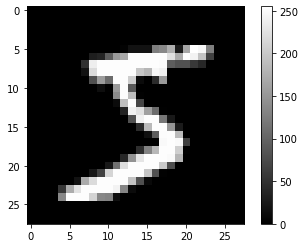

In [3]:
#  plot shape
print(dataset[0][0].shape)
# visualize a single image
import matplotlib.pyplot as plt

plt.imshow(dataset[0][0][0], cmap='gray')
plt.colorbar()
plt.show()

In [4]:
# helper function to visualize batches of images
import torch

def show_batch(batch: torch.Tensor):
    grid = torchvision.utils.make_grid(batch)
    plt.imshow(grid[0], cmap='gray')
    # plt.colorbar()
    plt.show()

### Integration of `batchgenerators` transformations into the augmentation pipeline.
Note: when batchgenerator transformations are integrated, gradients can not be propagated through
the transformation pipeline.

`batchgenerators` transformations are based on numpy to be framework agnostic. They are also based
on dictionaries which are modified through the transformations.

There are two steps which need to be integrated into your pipelin in order to the 
`batchgenerators` transforms

1. Exchange the `default_collate` function inside the dataloder with `numpy_collate`
2. When switching from `batchgenerators` transformations to `rising` transformations, insdert `ToTensor` transformation

In [34]:
# setup transforms
from rising.transforms import *
from rising.random import UniformParameter
from batchgenerators.transforms import ZeroMeanUnitVarianceTransform

transforms = []
# convert tuple into dict
transforms.append(SeqToMap("data", "label"))
# batchgenerators transforms
transforms.append(ZeroMeanUnitVarianceTransform())
# convert to tensor
transforms.append(ToTensor())
# rising transforms
transforms.append(Rot90((0, 1)))
transforms.append(Mirror(dims=(0, 1)))
transforms.append(Rotate([UniformParameter(0, 180)], adjust_size=True, degree=True))
# transforms.append(Resize([UniformParameter(0.8, 1.2)]))

In [35]:
from rising.loading import DataLoader, default_transform_call, numpy_collate
from rising.transforms import Compose

composed = Compose(transforms, transform_call=default_transform_call)
dataloader = DataLoader(dataset, batch_size=8, batch_transforms=composed,
                        num_workers=0, collate_fn=numpy_collate)

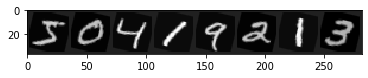

In [36]:
_iter = iter(dataloader)
batch = next(_iter)
show_batch(batch["data"])

### More libraries will be added in the future :) 
